In [1]:
from houseofreps import *
import numpy as np
import matplotlib.pyplot as plt
import csv 
import os
import pandas
from typing import List, Dict, Tuple


# Representation per citizen of each state

In [2]:
def save_fig(fname: str):
    if not os.path.isdir("figures"):
        os.makedirs('figures')
    s = os.path.join("figures/",fname)
    plt.savefig(s)

    print("Saved figure to: %s" % s)

In [25]:
def write_csv_residents_per_rep(fname: str, residents_per_rep: Dict[str, Dict[str, float]]):
    with open(fname, 'w') as csvfile: 

        # creating a csv writer object 
        csvwriter = csv.writer(csvfile) 
        
        # writing the fields
        header = ['year', 'state', 'residents per rep']
        csvwriter.writerow(header) 
            
        # writing the data rows 
        rows = []
        for year, d2 in residents_per_rep.items():
            for state, rpr in d2.items():
                rows.append([year, state, "%.8f" % rpr])

        csvwriter.writerows(rows)

In [26]:
house = HouseOfReps()

residents_per_rep = {}
for year in Year:
    residents_per_rep[year.value] = {}

    house.reset_pops_assigned_to_true(year, PopType.APPORTIONMENT)

    for st, state in house.states.items():
        if st != St.DISTRICT_OF_COLUMBIA:
            residents_per_rep[year.value][st.name] = 1e6 * state.pop_true[year].apportionment / state.no_reps_true[year].voting
            # print(st.name," ",residents_per_rep)
    
    fair = 1e6 * house.get_total_us_pop_true(year,PopType.APPORTIONMENT) / 435.0
    residents_per_rep[year.value]['fair'] = fair

# Write
write_csv_residents_per_rep("analyze_data/residents_per_rep.csv",residents_per_rep)

## Plot

Saved figure to: figures/no_residents_per_rep_2020.png


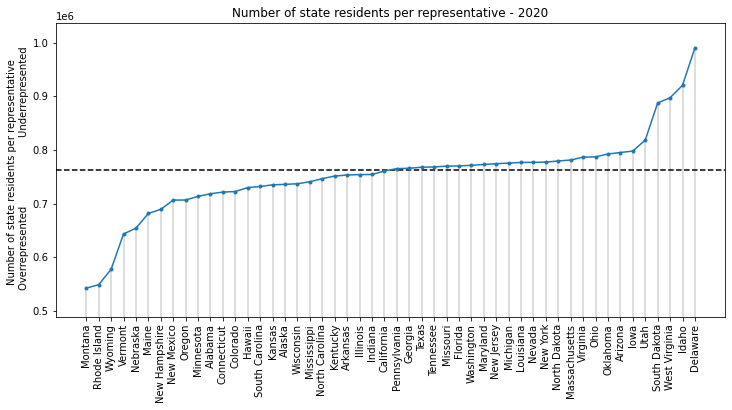

Saved figure to: figures/no_residents_per_rep_2010.png


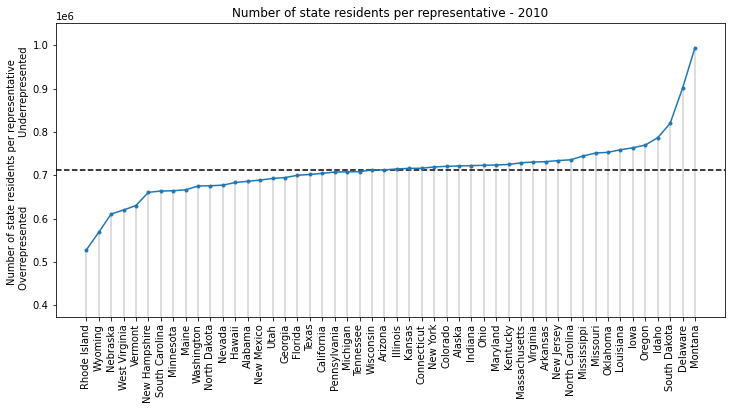

Saved figure to: figures/no_residents_per_rep_2000.png


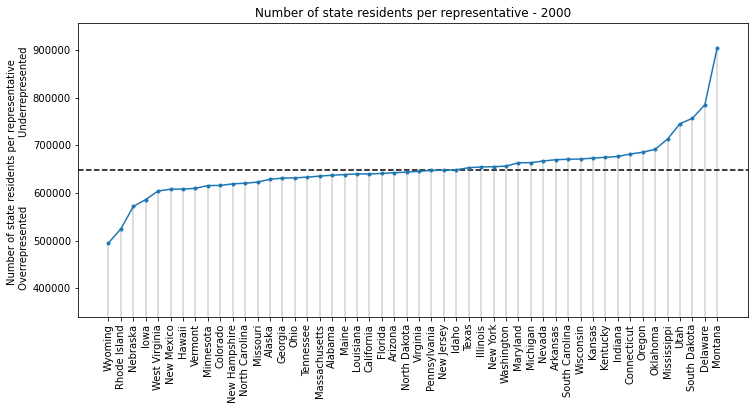

Saved figure to: figures/no_residents_per_rep_1990.png


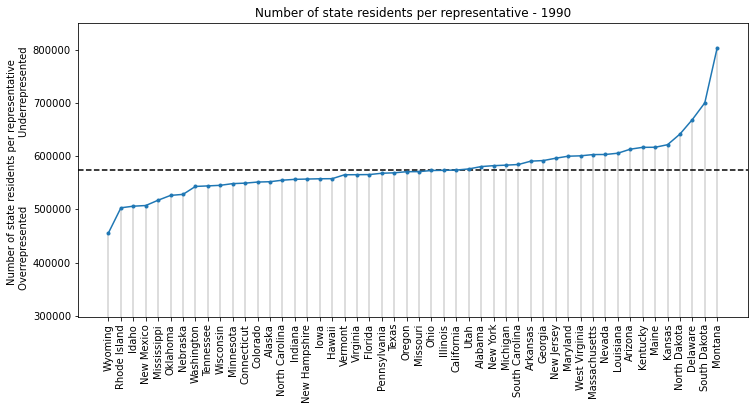

Saved figure to: figures/no_residents_per_rep_1980.png


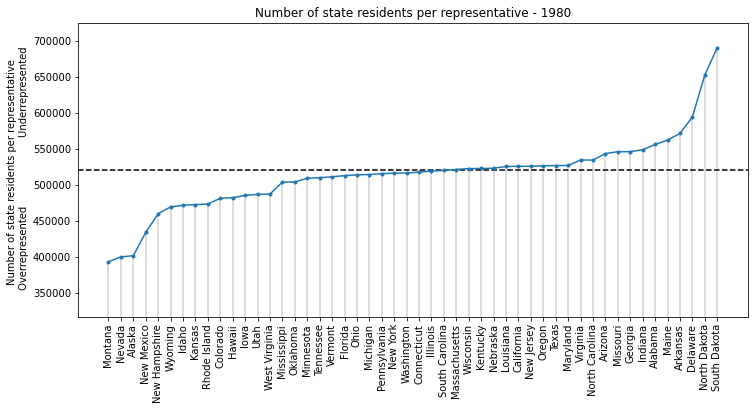

Saved figure to: figures/no_residents_per_rep_1970.png


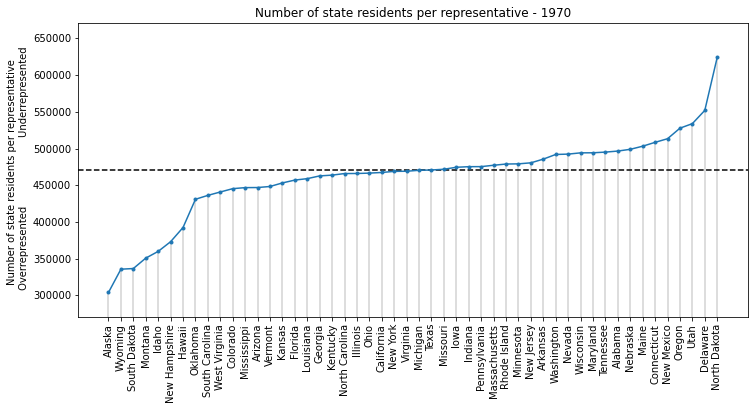

Saved figure to: figures/no_residents_per_rep_1960.png


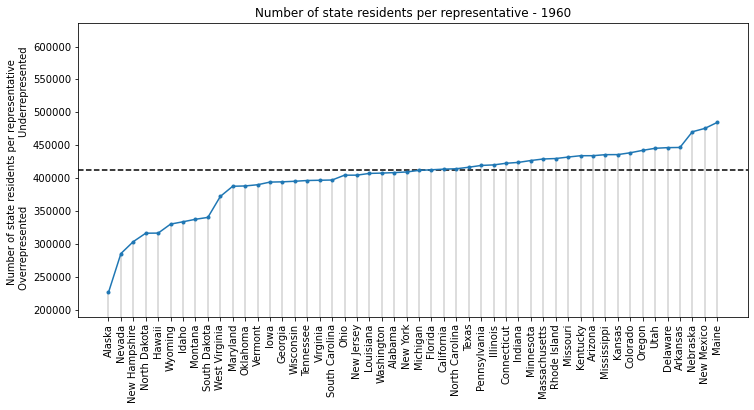

In [38]:
df = pd.read_csv('analyze_data/residents_per_rep.csv')

for year in Year:
    df_year = df[df['year'] == int(year.value)]
    fair = float(df_year[df_year['state'] == 'fair']['residents per rep'])
    df_year = df_year[df_year['state'] != 'fair']

    df_year = df_year.sort_values(by=['residents per rep'])

    xticks = list(df_year['state'])
    y = list(df_year['residents per rep'])
    x = np.arange(0,len(xticks))

    min_delta = fair - min(y)
    max_delta = max(y) - fair
    delta = 1.2*max(min_delta, max_delta)

    plt.figure(figsize=(12,6))
    plt.axhline(fair,linestyle='dashed',color='black')
    plt.xticks(x, xticks, rotation=90)
    plt.plot(x, y, '.-')
    plt.vlines(x, [0], y, color='lightgray')
    plt.ylabel("Number of state residents per representative \n Overrepresented                      Underrepresented")
    plt.ylim(fair-delta,fair+delta)
    plt.title('Number of state residents per representative - %s' % year.value)

    plt.subplots_adjust(bottom=0.2)
    save_fig('no_residents_per_rep_%s.png' % year.value)

    plt.show()

## Plot rankings as a bump chart in time

In [40]:
df = pd.read_csv('analyze_data/residents_per_rep.csv')

rankings = {}
for year in Year:
    df_year = df[df['year'] == int(year.value)]
    df_year = df_year[df_year['state'] != 'fair']

    df_year = df_year.sort_values(by=['residents per rep'])

    rankings[year] = list(df_year['state'])

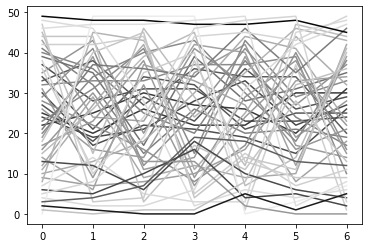

In [61]:
plt_data = {}
for st in [x for x in St if x != St.DISTRICT_OF_COLUMBIA]:
    x = np.arange(0,len(rankings))
    y = [ranks.index(st.name) for ranks in rankings.values()]

    # Color by the variance in the ranking to identify states that are consistently over/under represented
    mean = np.mean(y)
    std = np.std(y)

    plt_data[st] = (x,y,mean,std)

std_max = max([x[3] for x in plt_data.values()])
std_min = min([x[3] for x in plt_data.values()])

plt.figure()
for st, dat in plt_data.items():
    x, y, mean, std = dat
    col = 0.1 + 0.9 * (1 - pow(1 - (std-std_min) / (std_max - std_min),4))
    plt.plot(x, y, color=(col,col,col))

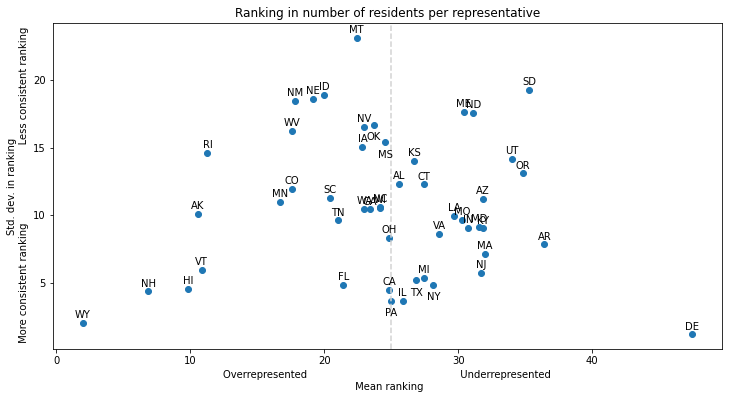

In [81]:
mean_dat = [x[2] for x in plt_data.values()]
std_dat = [x[3] for x in plt_data.values()]
labels = [x.value for x in plt_data.keys()]

plt.figure(figsize=(12,6))
plt.axvline(25,color='lightgray',linestyle='dashed')
plt.scatter(mean_dat, std_dat)
plt.xlabel('Overrepresented                                                 Underrepresented\n Mean ranking')
plt.ylabel('Std. dev. in ranking\n More consistent ranking                         Less consistent ranking')
plt.title('Ranking in number of residents per representative')

downs = ['TX','NY','PA','OK','MS']
for i, txt in enumerate(labels):
    if txt in downs:
        xytext=(0,-15)
    else:
        xytext=(0,5)
    plt.annotate(
        txt, 
        (mean_dat[i], std_dat[i]),
        textcoords="offset points", # how to position the text
        xytext=xytext, # distance from text to points (x,y)
        ha='center'
        ) # horizontal alignment can be left, right or center

In [ ]:
# Delaware is consistently underrepresented
# Wyoming in consistently overrepresented
# Montana has the largest fluctuations in the rankings
# Not political; on the overrepresented side, there is Wyoming (dominantly republican), but also New Hampshire, Hawaii, Vermont which are all dominantly democrat
# On the underrepresented side there is Delaware (democrat), but also Arkansas, South Dakota and Utah (republican)

# Calculate how number of reps changes when population is increased/decreased, for each state

In [3]:
def write_csv(fname: str, pops_shift_millions: List[float], no_reps_assigned: Dict[St,List[Tuple[float,int,int]]]):
    with open(fname, 'w') as csvfile: 

        # creating a csv writer object 
        csvwriter = csv.writer(csvfile) 
        
        # writing the fields
        header = ['population shift (millions)']
        for st in no_reps_assigned.keys():
            header.append(st.value + " population (millions)")
            header.append(st.value + " no reps (voting)")
            header.append(st.value + " no reps (nonvoting)")
        
        csvwriter.writerow(header) 
            
        # writing the data rows 
        rows = []
        for i in range(0,len(list(no_reps_assigned.values())[0])):
            row = ["%.8f" % pops_shift_millions[i]]
            for nra in no_reps_assigned.values():
                row.append("%.8f" % nra[i][0]) # population (millions)
                row.append(nra[i][1]) # no voting reps
                row.append(nra[i][2]) # no nonvoting reps
            rows.append(row)

        csvwriter.writerows(rows)

In [8]:
def calculate_no_reps_assigned(house: HouseOfReps, year: Year, pops_shift_millions: List[float]) -> Dict[St,List[Tuple[float,int,int]]]:
    no_reps_assigned = {}
    for st2 in St:
        no_reps_assigned[st2] = []

    for pop_shift_millions in pops_shift_millions:
        house.reset_pops_assigned_to_true(year, PopType.APPORTIONMENT)
        try:
            house.shift_pop_from_entire_us_to_state(
                st_to=st, 
                pop_add_millions=pop_shift_millions, 
                verbose=False
                )
        except:
            # Population of state would be negative
            print("Stopping early - removing: %f people is more than the number of people in the state" % pop_shift_millions)
            break

        house.assign_house_seats_priority()

        for st2 in St:
            pop = house.states[st2].pop_assigned
            n1 = house.states[st2].no_reps_assigned.voting
            n2 = house.states[st2].no_reps_assigned.nonvoting
            no_reps_assigned[st2].append((pop,n1,n2))
    
    return no_reps_assigned

In [9]:
house = HouseOfReps()

# Population to add to the state, detracted from the rest of the USA
pops_add_millions = list(0.005*np.arange(0,201))
pops_lost_millions = list(-0.005*np.arange(0,201))

for year in Year:

    # For exporting data
    dir_name_add = 'analyze_data/population_add_%s' % year.value
    dir_name_lose = 'analyze_data/population_lose_%s' % year.value
    if not os.path.isdir(dir_name_add):
        os.makedirs(dir_name_add)
    if not os.path.isdir(dir_name_lose):
        os.makedirs(dir_name_lose)
    
    for st in St:
        print("Calculating for year: %s state: %s" % (year.value, st.name))
        
        no_reps_assigned = calculate_no_reps_assigned(house, year, pops_add_millions)
        write_csv(os.path.join(dir_name_add, '%s.csv' % st.value), pops_add_millions, no_reps_assigned)

        no_reps_assigned = calculate_no_reps_assigned(house, year, pops_lost_millions)
        write_csv(os.path.join(dir_name_lose, '%s.csv' % st.value), pops_lost_millions, no_reps_assigned)

Calculating for year: 2020 state: California
Calculating for year: 2020 state: Texas
Calculating for year: 2020 state: Florida
Calculating for year: 2020 state: New York
Calculating for year: 2020 state: Pennsylvania
Calculating for year: 2020 state: Illinois
Calculating for year: 2020 state: Ohio
Calculating for year: 2020 state: Georgia
Calculating for year: 2020 state: North Carolina
Calculating for year: 2020 state: Michigan
Calculating for year: 2020 state: New Jersey
Calculating for year: 2020 state: Virginia
Calculating for year: 2020 state: Washington
Calculating for year: 2020 state: Arizona
Calculating for year: 2020 state: Massachusetts
Calculating for year: 2020 state: Tennessee
Calculating for year: 2020 state: Indiana
Calculating for year: 2020 state: Missouri
Calculating for year: 2020 state: Maryland
Calculating for year: 2020 state: Wisconsin
Calculating for year: 2020 state: Colorado
Calculating for year: 2020 state: Minnesota
Calculating for year: 2020 state: South C

# Min population shift to get an additional representative

In [12]:
def write_csv_rep(fname: str, header: List[str], min_pop_changes_for_next_rep):
    with open(fname, 'w') as csvfile: 

        # creating a csv writer object 
        csvwriter = csv.writer(csvfile) 
        
        # writing the fields        
        csvwriter.writerow(header) 
            
        # writing the data rows 
        rows = []
        for i in range(0,len(min_pop_changes_for_next_rep)):
            st, min_pop_change_for_next_rep, st_lost, pop_lost = min_pop_changes_for_next_rep[i]
            row = [
                st.name,
                "%.4f" % min_pop_change_for_next_rep,
                st_lost.name,
                "%.4f" % pop_lost
            ]
            rows.append(row)

        csvwriter.writerows(rows)

In [20]:
def calc_min_pop_changes_for_next_rep(year: Year, verbose: bool):
    min_pop_changes_for_next_rep = []
    for st in [x for x in St if x != St.DISTRICT_OF_COLUMBIA]:
        # Import data
        fname = 'analyze_data/population_add_%s/%s.csv' % (year.value,st.value)
        df = pandas.read_csv(fname)
        
        pop_shifts_millions = df['population shift (millions)'].to_numpy()
        no_reps_voting = df['%s no reps (voting)' % st.value].to_numpy()

        ichange = -1
        for i in range(1,len(no_reps_voting)):
            if no_reps_voting[i] != no_reps_voting[0]:
                # Found it
                ichange = i
                break

        if ichange != -1:
            min_pop_change_for_next_rep = pop_shifts_millions[ichange]
        else:
            min_pop_change_for_next_rep = 10000
        
        # Who lost the rep?
        st_lost = None
        for st_2 in St:
            if st_2 == st:
                continue
            no_reps_2 = df['%s no reps (voting)' % st_2.value].to_numpy()
            if no_reps_2[0] != no_reps_2[ichange]:
                # This is the one
                if st_lost != None:
                    print("ERROR: 2 states lost a rep??? Something went wrong!")
                    assert False
                st_lost = st_2
        
        # Population lost in this state
        pop_lost = None
        if st_lost != None:
            pop_lost = df["%s population (millions)" % st_lost.value][0] - df["%s population (millions)" % st_lost.value][ichange]

        min_pop_changes_for_next_rep.append((st,min_pop_change_for_next_rep, st_lost, pop_lost))

    # Sort
    min_pop_changes_for_next_rep.sort(key = lambda x: x[1])
    if verbose:
        for x in min_pop_changes_for_next_rep:
            print("%s %s: min pop change for next rep (millions): %.4f state that lost the rep: %s pop lost: %s" % (year.value, x[0].value, x[1], x[2], x[3]))

    return min_pop_changes_for_next_rep

In [25]:
for year in Year:
    min_pop_changes_for_next_rep = calc_min_pop_changes_for_next_rep(year, verbose=False)

    header = ['state', 'min. population change for next rep', 'state that lost the rep', 'population this other state lost']
    write_csv_rep("analyze_data/one_more_rep_%s.csv" % year.value, header, min_pop_changes_for_next_rep)

In [34]:
_ = calc_min_pop_changes_for_next_rep(Year.YR2020, verbose=True)

2020 NY: min pop change for next rep (millions): 0.0050 state that lost the rep: St.MINNESOTA pop lost: 9.16300000000092e-05
2020 OH: min pop change for next rep (millions): 0.0150 state that lost the rep: St.MINNESOTA pop lost: 0.0002676499999996196
2020 ID: min pop change for next rep (millions): 0.0300 state that lost the rep: St.MINNESOTA pop lost: 0.0005191399999997515
2020 WV: min pop change for next rep (millions): 0.0750 state that lost the rep: St.MINNESOTA pop lost: 0.0012976599999996452
2020 AZ: min pop change for next rep (millions): 0.0800 state that lost the rep: St.MINNESOTA pop lost: 0.001407040000000137
2020 DE: min pop change for next rep (millions): 0.0900 state that lost the rep: St.MINNESOTA pop lost: 0.0015534099999996442
2020 VA: min pop change for next rep (millions): 0.1100 state that lost the rep: St.MINNESOTA pop lost: 0.00194362999999953
2020 UT: min pop change for next rep (millions): 0.1400 state that lost the rep: St.MINNESOTA pop lost: 0.0024332099999995

# Min population shift to lose a representative

In [29]:
def calc_min_pop_changes_for_losing_rep(year: Year, verbose: bool):
    min_pop_changes_for_losing_rep = []
    for st in St:
        # Import data
        fname = 'analyze_data/population_lose_%s/%s.csv' % (year.value,st.value)
        df = pandas.read_csv(fname)
        
        pop_shifts_millions = df['population shift (millions)'].to_numpy()
        no_reps_voting = df['%s no reps (voting)' % st.value].to_numpy()

        ichange = -1
        for i in range(1,len(no_reps_voting)):
            if no_reps_voting[i] != no_reps_voting[0]:
                # Found it
                ichange = i
                break

        if ichange == -1:
            continue
        min_pop_change_for_losing_rep = pop_shifts_millions[ichange]

        # Who gained the rep?
        st_gained = None
        for st_2 in St:
            if st_2 == st:
                continue
            no_reps_2 = df['%s no reps (voting)' % st_2.value].to_numpy()
            if no_reps_2[0] != no_reps_2[ichange]:
                # This is the one
                if st_gained != None:
                    print("ERROR: 2 states gaining a rep??? Something went wrong!")
                    assert False
                st_gained = st_2
        
        # Population gained in this state
        pop_gained = None
        if st_gained != None:
            pop_gained = df["%s population (millions)" % st_gained.value][ichange] - df["%s population (millions)" % st_gained.value][0]

        min_pop_changes_for_losing_rep.append((st, min_pop_change_for_losing_rep, st_gained, pop_gained))

    # Sort
    min_pop_changes_for_losing_rep.sort(key = lambda x: -x[1])
    if verbose:
        for x in min_pop_changes_for_losing_rep:
            print("%s: min pop change for losing rep (millions): %.4f state that gained the rep: %s pop gained: %s" % (x[0], x[1], x[2], x[3]))

    return min_pop_changes_for_losing_rep

In [31]:
for year in Year:
    min_pop_changes_for_losing_rep = calc_min_pop_changes_for_losing_rep(year, verbose=False)

    header = ['state', 'min. population change for losing rep', 'state that gained the rep', 'population this other state gained']
    write_csv_rep("analyze_data/one_less_rep_%s.csv" % year.value, header, min_pop_changes_for_losing_rep)

In [35]:
_ = calc_min_pop_changes_for_losing_rep(Year.YR2020, verbose=True)

St.MINNESOTA: min pop change for losing rep (millions): -0.0050 state that gained the rep: St.NEW_YORK pop gained: 0.00030996999999999275
St.MONTANA: min pop change for losing rep (millions): -0.0100 state that gained the rep: St.NEW_YORK pop gained: 0.0006112799999975493
St.RHODE_ISLAND: min pop change for losing rep (millions): -0.0200 state that gained the rep: St.NEW_YORK pop gained: 0.0012225999999984083
St.OREGON: min pop change for losing rep (millions): -0.0650 state that gained the rep: St.NEW_YORK pop gained: 0.004011589999997511
St.COLORADO: min pop change for losing rep (millions): -0.0750 state that gained the rep: St.NEW_YORK pop gained: 0.004650639999997708
St.ALABAMA: min pop change for losing rep (millions): -0.0850 state that gained the rep: St.NEW_YORK pop gained: 0.005258590000000396
St.NEBRASKA: min pop change for losing rep (millions): -0.0950 state that gained the rep: St.NEW_YORK pop gained: 0.005822599999998346
St.NORTH_CAROLINA: min pop change for losing rep (

## Plot one more/less rep

In [87]:
def plt_year_sorted_by_one_more_rep(year: Year):
    df_less = pd.read_csv('analyze_data/one_less_rep_%s.csv' % year.value)
    df_more = pd.read_csv('analyze_data/one_more_rep_%s.csv' % year.value)

    xticks_more = df_more['state'].to_numpy()
    y_more = 1e6 * df_more['min. population change for next rep'].to_numpy()
    x_more = np.arange(0,len(xticks_more))

    map_st_to_idx = {}
    for i in range(0,len(xticks_more)):
        map_st_to_idx[xticks_more[i]] = x_more[i]

    xticks_less = df_less['state'].to_numpy()
    y_less = 1e6 * df_less['min. population change for losing rep'].to_numpy()
    x_less = [ map_st_to_idx[xtick] for xtick in xticks_less ]

    # plt.figure()
    # plt.plot(x_less,y_less,'.')
    # plt.xticks(x, xticxs, rotation=90)

    plt.figure(figsize=(12,6))
    plt.xticks(x_more, xticks_more, rotation=90)
    plt.axhline(0,color='lightgray',linestyle='dashed')
    plt.plot(x_more,y_more,'.')
    plt.vlines(x_more, [-1000000], y_more, color='lightgray')
    plt.plot(x_less,y_less,'.')
    plt.ylim(-1000000,1000000)
    plt.ylabel("No. residents needed to add/lose one rep.")
    plt.xlabel("Less favorable                                                                                                                                                       More favorable")
    plt.title("No. residents needed to add/lose one rep. - %s" % year.value)

    save_fig('one_more_less_rep_%s.png' % year.value)
    plt.show()

In [101]:
def plt_year_sorted_by_one_less_rep(year: Year):
    df_less = pd.read_csv('analyze_data/one_less_rep_%s.csv' % year.value)
    df_more = pd.read_csv('analyze_data/one_more_rep_%s.csv' % year.value)

    xticks_less = df_less['state'].to_numpy()
    y_less = 1e6 * df_less['min. population change for losing rep'].to_numpy()
    x_less = np.arange(0,len(xticks_less))

    map_st_to_idx = {}
    for i in range(0,len(xticks_less)):
        map_st_to_idx[xticks_less[i]] = x_less[i]

    xticks_more = np.flip(df_more['state'].to_numpy())
    y_more = np.flip(1e6 * df_more['min. population change for next rep'].to_numpy())
    x_more = []
    next_idx = len(x_less)
    for xtick in xticks_more:
        if xtick in map_st_to_idx:
            x_more.append(map_st_to_idx[xtick])
        else:
            x_more.append(next_idx)
            next_idx += 1

    # plt.figure()
    # plt.plot(x_less,y_less,'.')
    # plt.xticks(x, xticxs, rotation=90)

    plt.figure(figsize=(12,6))
    plt.xticks(x_more, xticks_more, rotation=90)
    plt.axhline(0,color='lightgray',linestyle='dashed')
    plt.plot(x_more,y_more,'.')
    plt.vlines(x_more, [-1000000], y_more, color='lightgray')
    plt.plot(x_less,y_less,'.')
    plt.ylim(-1000000,1000000)
    plt.ylabel("No. residents needed to add/lose one rep.")
    plt.xlabel("More favorable                                                                                                                                                       Less favorable")
    plt.title("No. residents needed to add/lose one rep. - %s" % year.value)

    save_fig('one_more_less_rep_%s.png' % year.value)
    plt.show()

Saved figure to: figures/one_more_less_rep_2020.png


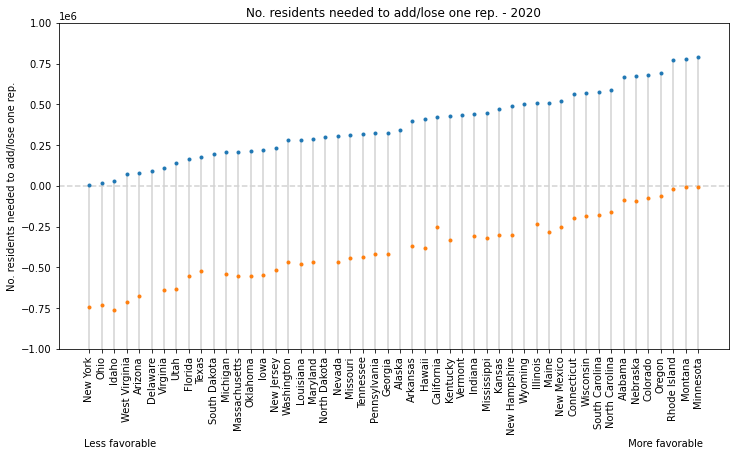

Saved figure to: figures/one_more_less_rep_2010.png


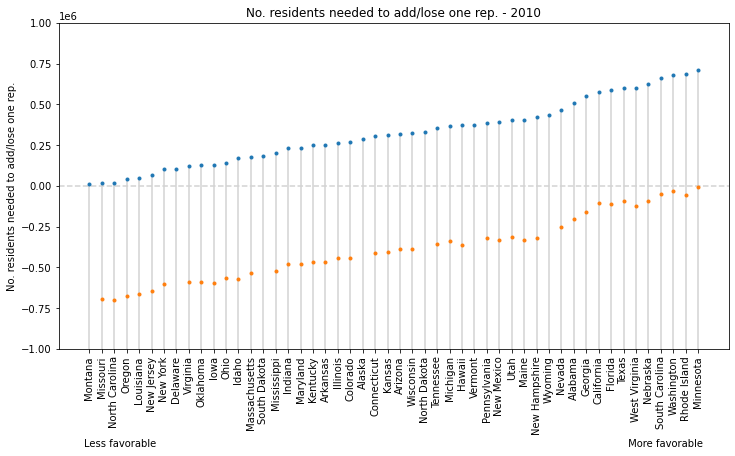

Saved figure to: figures/one_more_less_rep_2000.png


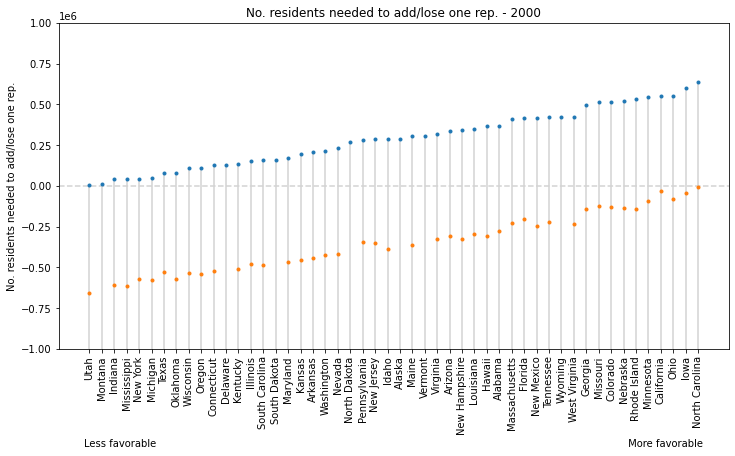

Saved figure to: figures/one_more_less_rep_1990.png


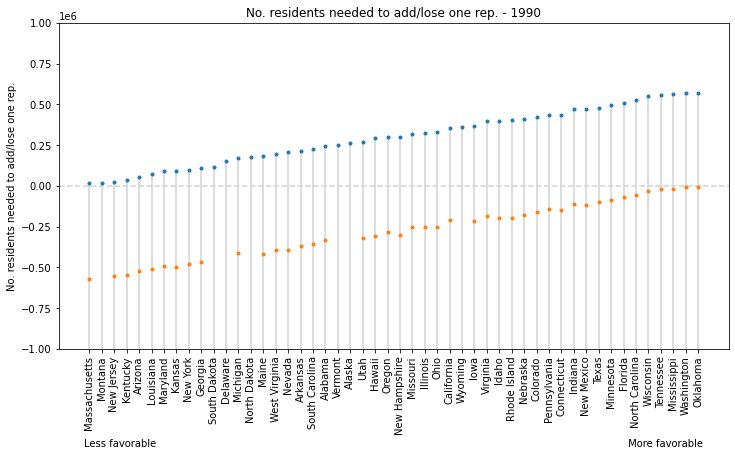

Saved figure to: figures/one_more_less_rep_1980.png


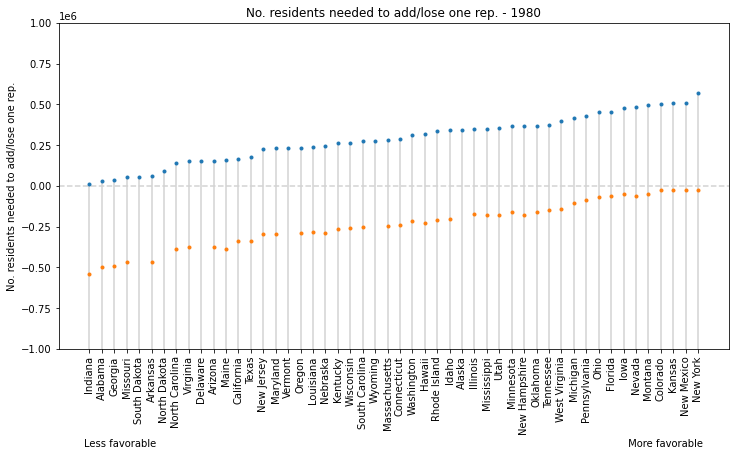

Saved figure to: figures/one_more_less_rep_1970.png


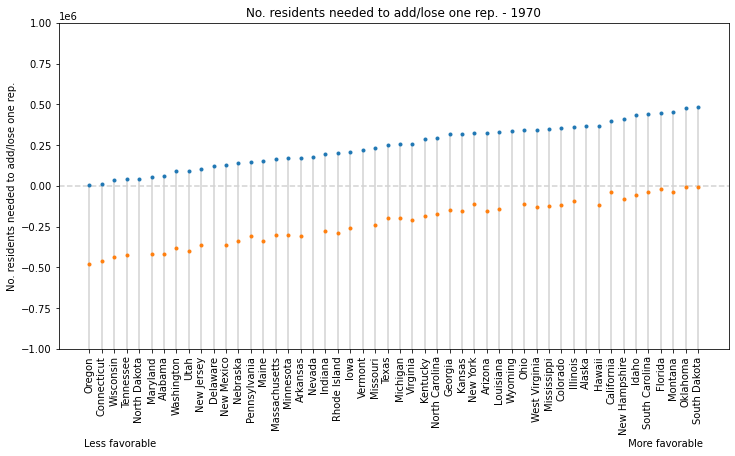

Saved figure to: figures/one_more_less_rep_1960.png


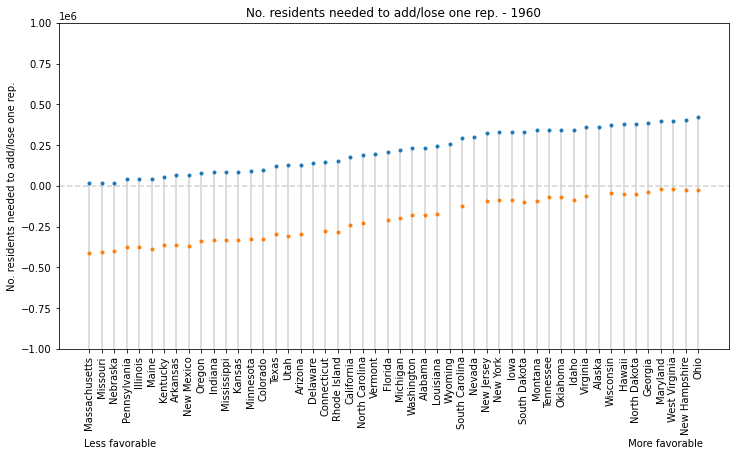

In [108]:
for year in Year:
    plt_year_sorted_by_one_more_rep(year)

## Rankings

In [109]:
rankings = {}
for year in Year:
    df_year = pd.read_csv('analyze_data/one_more_rep_%s.csv' % year.value)
    df_year = df_year.sort_values(by=['min. population change for next rep'])

    rankings[year] = list(df_year['state'])

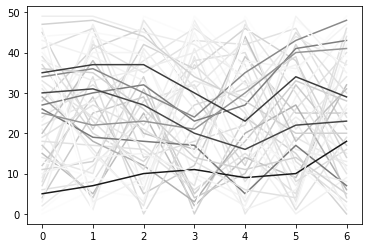

In [110]:
plt_data = {}
for st in [x for x in St if x != St.DISTRICT_OF_COLUMBIA]:
    x = np.arange(0,len(rankings))
    y = [ranks.index(st.name) for ranks in rankings.values()]
    
    # Color by the variance in the ranking to identify states that are consistently over/under represented
    mean = np.mean(y)
    std = np.std(y)

    plt_data[st] = (x,y,mean,std)

std_max = max([x[3] for x in plt_data.values()])
std_min = min([x[3] for x in plt_data.values()])

plt.figure()
for st, dat in plt_data.items():
    x, y, mean, std = dat
    col = 0.1 + 0.9 * (1 - pow(1 - (std-std_min) / (std_max - std_min),3))
    plt.plot(x, y, color=(col,col,col))

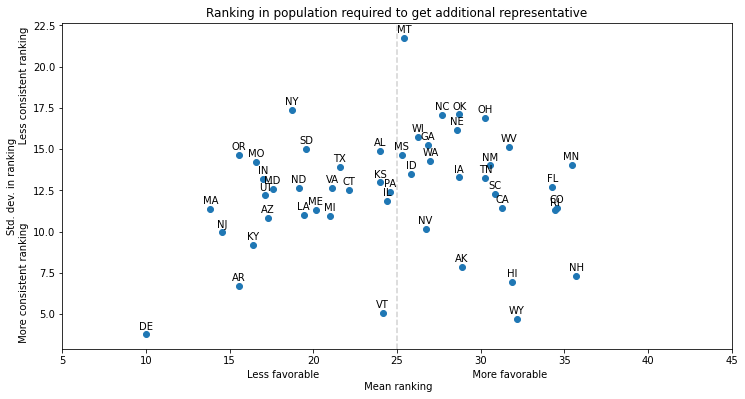

In [111]:
mean_dat = [x[2] for x in plt_data.values()]
std_dat = [x[3] for x in plt_data.values()]
labels = [x.value for x in plt_data.keys()]

plt.figure(figsize=(12,6))
plt.axvline(25,color='lightgray',linestyle='dashed')
plt.scatter(mean_dat, std_dat)
plt.xlabel('Less favorable                                                 More favorable\n Mean ranking')
plt.ylabel('Std. dev. in ranking\n More consistent ranking                         Less consistent ranking')
plt.title('Ranking in population required to get additional representative')
plt.xlim(5,45)

for i, txt in enumerate(labels):
    xytext=(0,5)
    plt.annotate(
        txt, 
        (mean_dat[i], std_dat[i]),
        textcoords="offset points", # how to position the text
        xytext=xytext, # distance from text to points (x,y)
        ha='center'
        ) # horizontal alignment can be left, right or center

## 2D ranking by additional residents and representation per state

In [140]:
rankings_omr = {}
for year in Year:
    df_year = pd.read_csv('analyze_data/one_more_rep_%s.csv' % year.value)
    df_year = df_year.sort_values(by=['min. population change for next rep'])

    rankings_omr[year] = list(np.flip(list(df_year['state'])))

df = pd.read_csv('analyze_data/residents_per_rep.csv')
rankings_rpr = {}
for year in Year:
    df_year = df[df['year'] == int(year.value)]
    df_year = df_year[df_year['state'] != 'fair']

    df_year = df_year.sort_values(by=['residents per rep'])

    rankings_rpr[year] = list(df_year['state'])

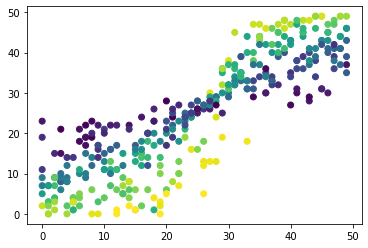

In [150]:
x = []
y = []
cols = []
for year in Year:
    for i,st in enumerate([x for x in St if x != St.DISTRICT_OF_COLUMBIA]):
        x.append(rankings_omr[year].index(st.name))
        y.append(rankings_rpr[year].index(st.name))
        cols.append(i)

plt.scatter(x,y,c=cols)

In [141]:
mean_omr = []
mean_rpr = []
labels = []
for st in [x for x in St if x != St.DISTRICT_OF_COLUMBIA]:
    labels.append(st.value)

    y_omr = [ranks.index(st.name) for ranks in rankings_omr.values()]
    mean_omr.append(np.mean(y_omr))

    y_rpr = [ranks.index(st.name) for ranks in rankings_rpr.values()]
    mean_rpr.append(np.mean(y_rpr))

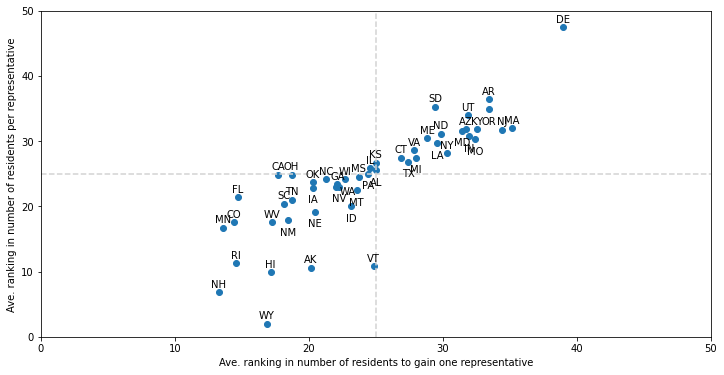

In [142]:
plt.figure(figsize=(12,6))
plt.axvline(25,color='lightgray',linestyle='dashed')
plt.axhline(25,color='lightgray',linestyle='dashed')
plt.scatter(mean_omr,mean_rpr)
plt.xlim(0,50)
plt.ylim(0,50)
plt.xlabel('Ave. ranking in number of residents to gain one representative')
plt.ylabel('Ave. ranking in number of residents per representative')

rights = 'WA'
unders = ['OR','MO','IN','LA','MI','TX','MD','NM','AL','IA','NE','MT','ID','NV','PA']
for i, txt in enumerate(labels):
    if txt in unders:
        xytext=(0,-15)
    elif txt in rights:
        xytext=(12,-8)
    else:
        xytext=(0,5)
    plt.annotate(
        txt, 
        (mean_omr[i], mean_rpr[i]),
        textcoords="offset points", # how to position the text
        xytext=xytext, # distance from text to points (x,y)
        ha='center'
        ) # horizontal alignment can be left, right or center

## 2D rankings by raw values

Saved figure to: figures/favorable2d_2020.png


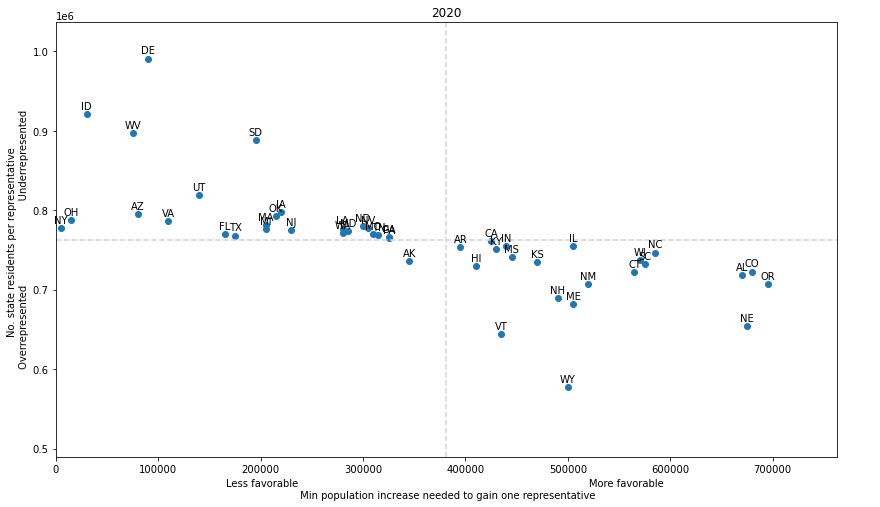

Saved figure to: figures/favorable2d_2010.png


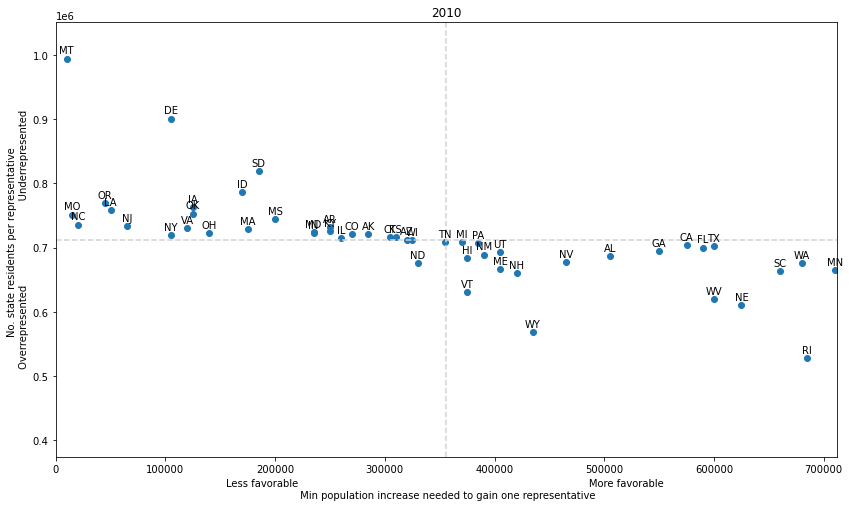

Saved figure to: figures/favorable2d_2000.png


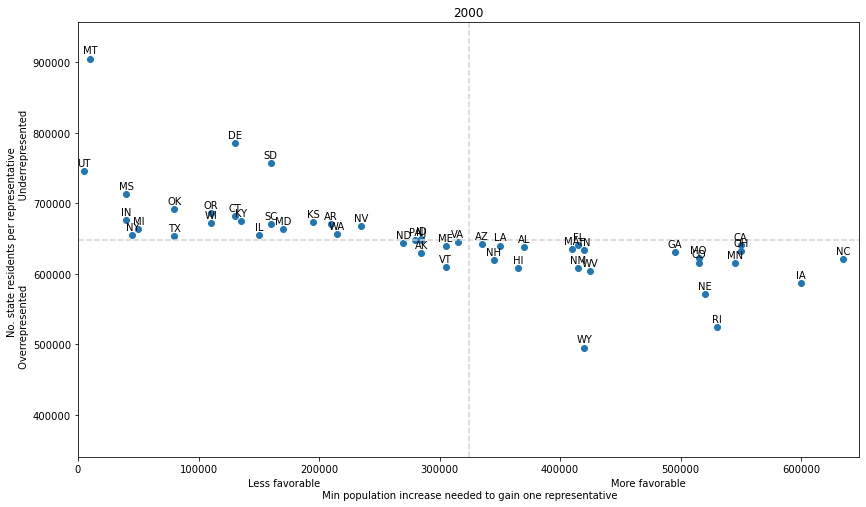

Saved figure to: figures/favorable2d_1990.png


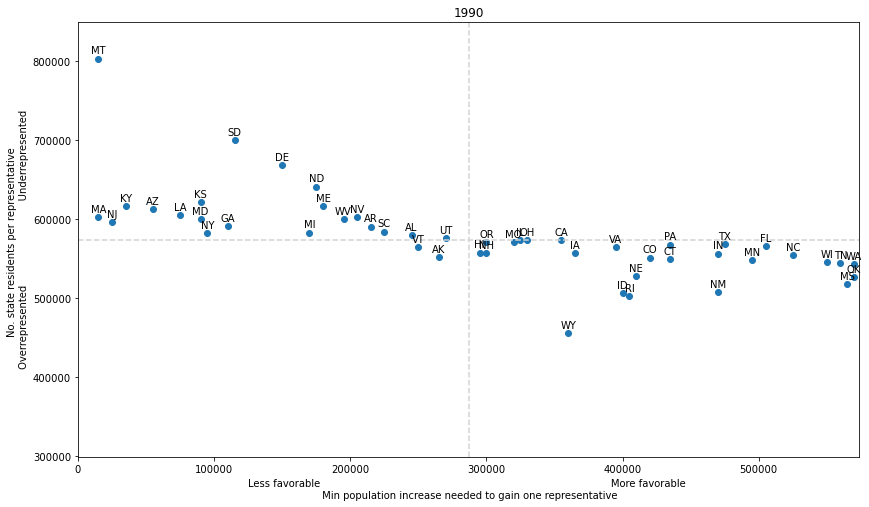

Saved figure to: figures/favorable2d_1980.png


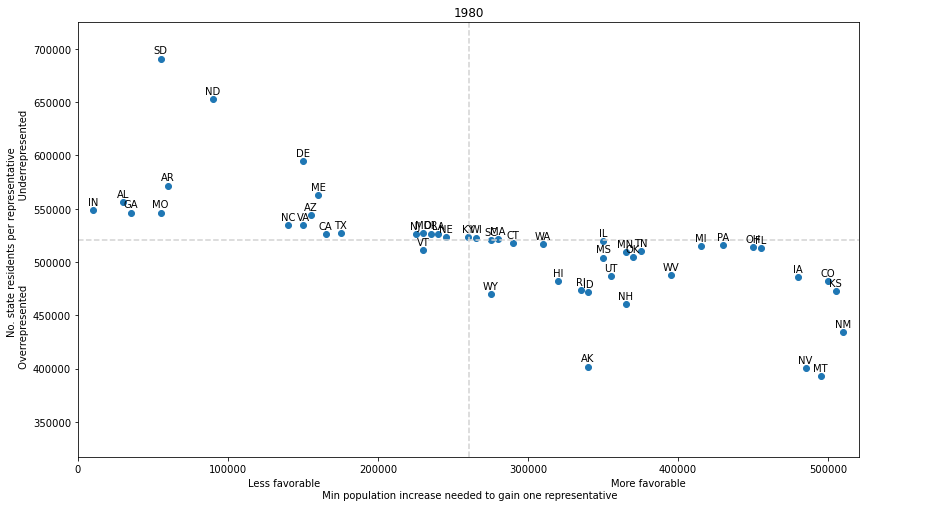

Saved figure to: figures/favorable2d_1970.png


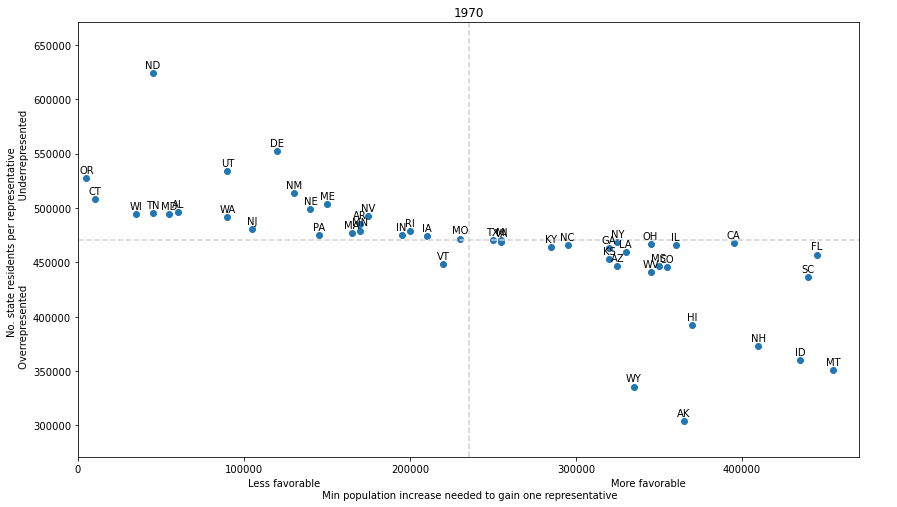

Saved figure to: figures/favorable2d_1960.png


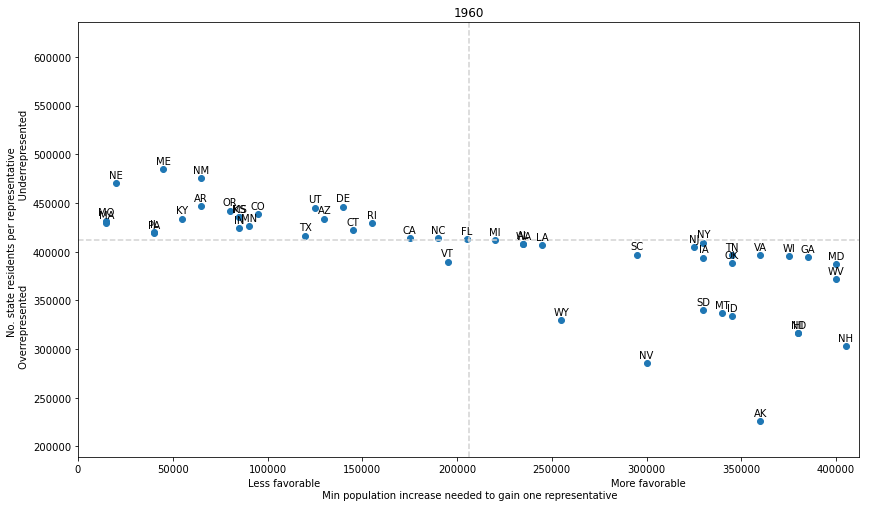

In [64]:
# Import
for year in Year:
    df_more = pd.read_csv('analyze_data/one_more_rep_%s.csv' % year.value)
    df_res = pd.read_csv('analyze_data/residents_per_rep.csv')
    df_res = df_res[df_res['year'] == int(year.value)]

    # Plotting data
    plt_data = {}
    for idx, row in df_more.iterrows():
        state = row['state']
        st = St.fromName(state)
        dpop = 1e6*row['min. population change for next rep']
        cpr = float(df_res[df_res['state'] == st.name]['residents per rep'])
        plt_data[st] = [dpop, cpr]

    fair = float(df_res[df_res['state'] == 'fair']['residents per rep'])

    # Scatter plot
    x = [p[0] for p in plt_data.values()]
    y = [p[1] for p in plt_data.values()]
    labels = [x.value for x in list(plt_data.keys())]

    min_delta = fair - min(y)
    max_delta = max(y) - fair
    delta = 1.2*max(min_delta, max_delta)

    plt.figure(figsize=(14,8))
    plt.scatter(x,y)
    plt.ylabel("No. state residents per representative \n Overrepresented                           Underrepresented")

    plt.axhline(fair,color='lightgray',linestyle='dashed')
    plt.ylim(fair-delta,fair+delta)
    plt.xlim(0,fair)
    plt.axvline(0.5*fair,color='lightgray',linestyle='dashed')
    plt.xlabel("Less favorable                                                                                             More favorable \n Min population increase needed to gain one representative")
    plt.title('%s' % year.value)

    for i, txt in enumerate(labels):
        plt.annotate(
            txt, 
            (x[i], y[i]),
            textcoords="offset points", # how to position the text
            xytext=(0,5), # distance from text to points (x,y)
            ha='center'
            ) # horizontal alignment can be left, right or center

    save_fig('favorable2d_%s.png' % year.value)
    plt.show()